In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 720 kB 7.5 MB/s 
     |████████████████████████████████| 1.2 MB 42.7 MB/s 
     |████████████████████████████████| 186 kB 77.5 MB/s 
     |████████████████████████████████| 46 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 51 kB 402 kB/s 


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [13]:
import os
os.environ['AZURE_SEARCH_KEY'] = #key
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [14]:
results = search_images_bing(key, 'persian cat')
ims = results.attrgot('contentUrl')
len(ims)

150

In [17]:
dest = 'images/first.jpg'
download_url(ims[1], dest)

Path('images/first.jpg')

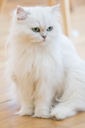

In [18]:
im = Image.open(dest)
im.to_thumb(128,128)

In [20]:
feline_types = 'tiger','cat','lion', 'panther', 'leopard'
path = Path('felines')

In [21]:
if not path.exists():
    path.mkdir()
    for o in feline_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [22]:
for cat in os.listdir(path):
  for img in os.listdir(path/cat):
    if cat not in img:
      src = path/cat/img
      dest = path / cat / (cat+img)
      os.rename(src, dest)

In [23]:
fns = get_image_files(path)
fns

(#707) [Path('felines/cat/cat00000027.jpg'),Path('felines/cat/cat00000026.jpg'),Path('felines/cat/cat00000036.jpg'),Path('felines/cat/cat00000095.jpg'),Path('felines/cat/cat00000039.jpg'),Path('felines/cat/cat00000122.jpg'),Path('felines/cat/cat00000089.jpg'),Path('felines/cat/cat00000132.jpg'),Path('felines/cat/cat00000093.jpg'),Path('felines/cat/cat00000008.jpg')...]

In [24]:
failed = verify_images(fns)
failed

(#8) [Path('felines/cat/cat00000091.jpg'),Path('felines/cat/cat00000146.jpg'),Path('felines/tiger/tiger00000046.jpg'),Path('felines/tiger/tiger00000131.jpg'),Path('felines/tiger/tiger00000106.jpg'),Path('felines/leopard/leopard00000031.jpg'),Path('felines/leopard/leopard00000124.jpg'),Path('felines/leopard/leopard00000086.jpg')]

In [25]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [26]:
felines = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [27]:
dls = felines.dataloaders(path)

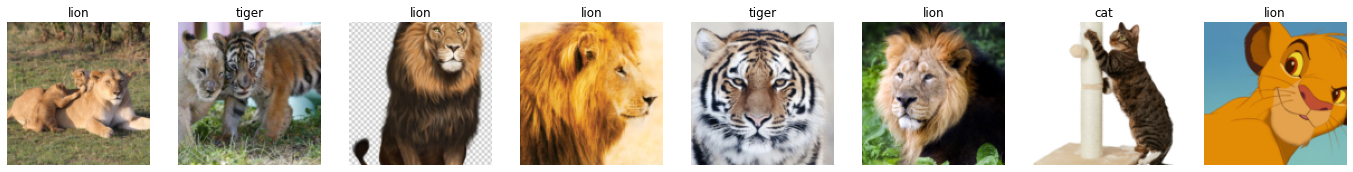

In [28]:
dls.valid.show_batch(max_n=8, nrows=1)

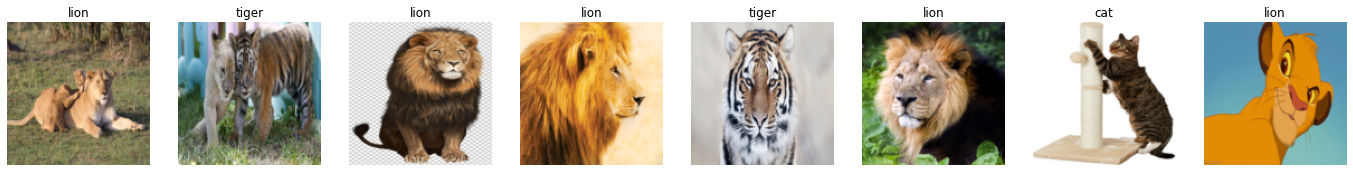

In [29]:
felines = felines.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = felines.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=1)

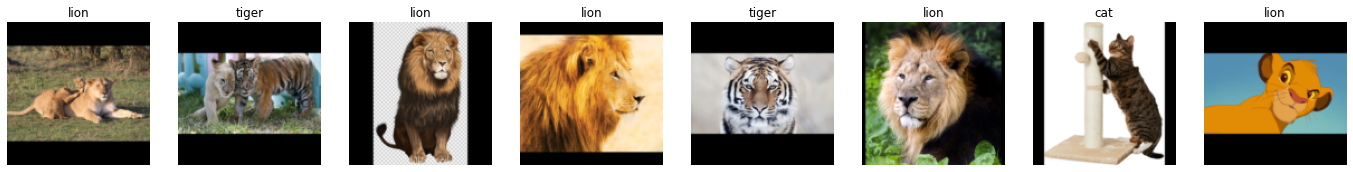

In [30]:
felines = felines.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = felines.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=1)

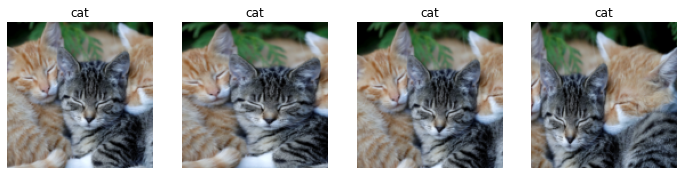

In [31]:
felines = felines.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = felines.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


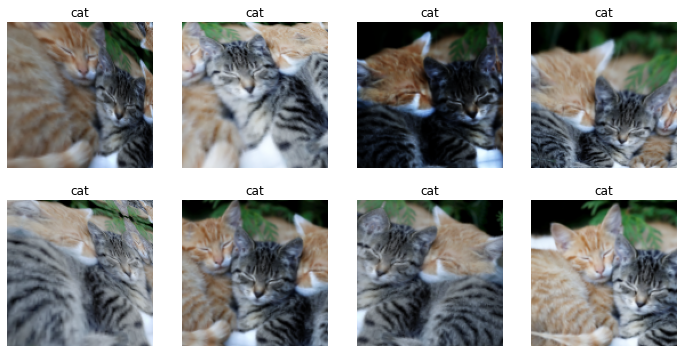

In [32]:
felines = felines.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = felines.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [54]:
felines = felines.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = felines.dataloaders(path)

In [55]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.880849,0.273089,0.896000,00:39


epoch,train_loss,valid_loss,accuracy,time
0,0.340211,0.180240,0.936000,00:39
1,0.272399,0.153140,0.944000,00:39
2,0.209951,0.116923,0.952000,00:39
3,0.170330,0.115904,0.960000,00:39


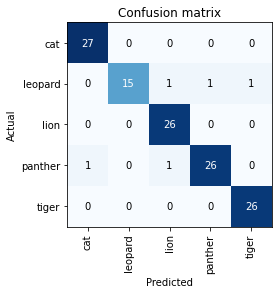

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [59]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [53]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
from google.colab import files
!zip -r /content/felines.zip /content/felines
files.download("/content/felines.zip")

## Turning Your Model into an Online Application

### Using the Model for Inference

In [60]:
learn.export()

In [62]:
from google.colab import files
files.download("/content/export.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [19]:
learn_inf = load_learner(path/'export.pkl')

In [20]:
learn_inf.predict('images/first.jpg')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


('cat',
 tensor(0),
 tensor([9.9994e-01, 1.1286e-05, 3.8036e-05, 1.8370e-06, 5.9920e-06]))

In [21]:
learn_inf.dls.vocab

['cat', 'leopard', 'lion', 'panther', 'tiger']

### Creating a Notebook App from the Model

In [25]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn_upload.data[-1])

In [30]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)

In [32]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: panther; Probability: 1.0000')

In [33]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [39]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
> Deep learning algorithms are generally not good at recognizing images that are significantly different in structure or style to those used to train the model. For instance, if there were no black-and-white images in the training data, the model may do poorly on black-and-white images. Similarly, if the training data did not contain hand-drawn images, then the model will probably do poorly on hand-drawn images.

1. Where do text models currently have a major deficiency?
> However, deep learning is currently not good at generating correct responses! We don't currently have a reliable way to, for instance, combine a knowledge base of medical information with a deep learning model for generating medically correct natural language responses. This is very dangerous, because it is so easy to create content that appears to a layman to be compelling, but actually is entirely incorrect.

1. What are possible negative societal implications of text generation models?
> Another concern is that context-appropriate, highly compelling responses on social media could be used at massive scale—thousands of times greater than any troll farm previously seen—to spread disinformation, create unrest, and encourage conflict.

1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
> It is not recommended to use DL to entirely automate a process. Instead, we can use it as a part of process in which the model and humans interacts closely. This can make humans much more productive than they would be with manual methods. For instance, we could identify potential diseases from scans, to sort them in order of priority.

1. What kind of tabular data is deep learning particularly good at?
> Natural language and high-cardinality categorical data.

1. What's a key downside of directly using a deep learning model for recommendation systems?
> Nearly all ML approaches only tell you what products a particular user might like, rather that what would be helpful for a user. For instance, a recommendation system may recommend products that the user is already familiar with, or that has already purchased with different packaging.

1. What are the steps of the Drivetrain Approach?
> 1. Define a objective.
> 1. Think about what actions you can take.
> 1. Think about what data you have or can acquire.
> 1. Build a model.

1. How do the steps of the Drivetrain Approach map to a recommendation system?
> 1. The objective is to drive additional sales recommending products to users they would not purchase without the recommendation.
> 1. The actions we can take is ranking the possible recommendations.
> 1. We need to collect new data about a wide range of recommendations for a wide range of customers.
> 1. Finally, we can build a model.

1. Create an image recognition model using data you curate, and deploy it on the web.

1. What is `DataLoaders`?
> A fastai class that stores multiple `DataLoader` objects you pass to it, and makes them available as `train` and `valid`.

1. What four things do we need to tell fastai to create `DataLoaders`?
> 1. The kinds of data we are working with.
> 1. How to get the list of items.
> 1. How to label these items.
> 1. How to create the validation set.

1. What does the `splitter` parameter to `DataBlock` do?
> Defines a way to split up the dataset into train and validation subsets.

1. How do we ensure a random split always gives the same validation set?
> Using the `seed` parameter, with which the list of randomly generated numbers will always be the same.

1. What letters are often used to signify the independent and dependent variables?
> `x` for the independent variable and `y` for the dependent variable.

1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
> - By default `Resize` crops the image to fit the requested size. This can result in losing some important details. 
> - We can pad the images in order to keep their proportions, with the downside of wasting computation because of the empty space and resulting in a lower resolution for the part of image we actually use.
> - Squishing or stretching the images will cause they end up as unrealistic shapes, leading to a model that learns things that look different to how the actually are.

1. What is data augmentation? Why is it needed?
> *Data augmentation* refers to creating random variations of our input data, such they appear different, but do not actually change the meaning of the data. Thanks to DA we can significantly increase our images dataset. Additionally, this technique helps the model to learn the basic concept of what a object is, which leads to better generalization.

1. What is the difference between `item_tfms` and `batch_tfms`?
> - `item_tfms` can be used to define a function that will be applied to each individual item of our input. `batch_tfms` works in a similar way, but it is applied to the whole batch of items. `item_tfms` are applied using the CPU, while `batch_tfms` uses GPU (so it is faster and more efficient).

1. What is a confusion matrix?
> The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly.

1. What does `export` save?
>  - Model's architecture.
>  - Model's trained parameters.
>  - The definition of how to create `DataLoaders`. 

1. What is it called when we use a model for getting predictions, instead of training?
> Inference.

1. What are IPython widgets?
> GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook.

1. When might you want to use CPU for deployment? When might GPU be better?
> - There are a few reasons:
>    - GPUs are only useful when do lots of identical work in parallel, but you will normally classify just one image at a time.
>    - GPUs are complex to deal with.
>    - There is more market competition in CPU than GPU servers, as a result of which there are cheaper CPU services.      
> - GPUs are essential in the trainig process.

1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
> These approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc.

1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
> - Handling nighttime images, which may not appear in this dataset.
> - Dealing with low-resolution camera images.
> - Recognizing bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera).

1. What is "out-of-domain data"?
> Very different data than what model saw during training.

1. What is "domain shift"?
> A problem that occurs when the type of data our model sees changes over time.

1. What are the three steps in the deployment process?
> 1. Manual process.
> 1. Limited scope deployment.
> 1. Gradual expansion.

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.